# Jupiter(-like planets) Cloud Model using Ackerman and Marley Cloud Model.

Here, we try to compute a cloud opacity using Ackerman and Marley Model.
We consider ammonia and water clouds.  


In [1]:
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

Setting a simple atmopheric model. We need the density of atmosphere.

In [2]:
from exojax.utils.constants import kB, m_u
from exojax.atm.atmprof import pressure_layer_logspace

Parr, dParr, k = pressure_layer_logspace(log_pressure_top=-5., log_pressure_btm=4.0, nlayer=100)
alpha = 0.097
T0 = 200.
Tarr = T0 * (Parr)**alpha

mu = 2.0  # mean molecular weight
R = kB / (mu * m_u)
rho = Parr / (R * Tarr)


The solar abundance can be obtained using utils.zsol.nsol. Here, we assume a maximum VMR for NH3 and H2O from solar abundance. 

In [3]:
from exojax.utils.zsol import nsol

n = nsol()  #solar abundance
VMR_h2o = n["O"]
VMR_nh3 = n["N"]


Vapor saturation pressures can be obtained using atm.psat

In [4]:
from exojax.atm.psat import psat_ammonia_AM01, psat_water_AM01
psat_nh3 = psat_ammonia_AM01(Tarr)
psat_h2o = psat_water_AM01(Tarr)


Compute a cloud base pressure.

In [5]:
from exojax.atm.amclouds import compute_cloud_base_pressure

pbase_nh3 = compute_cloud_base_pressure(Parr, psat_nh3, VMR_nh3)
pbase_h2o = compute_cloud_base_pressure(Parr, psat_h2o, VMR_h2o)


The cloud base is located at the intersection of a TP profile and the vapor saturation puressure devided by VMR.

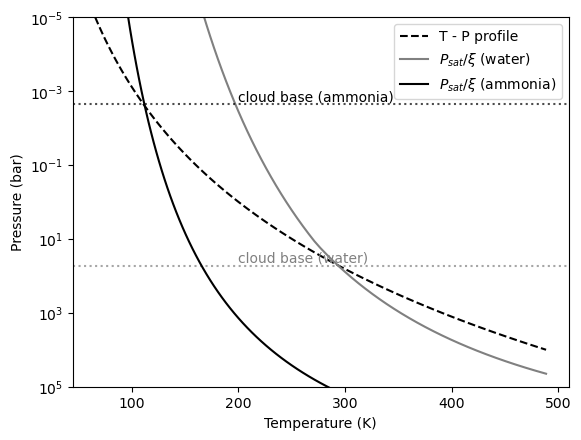

In [6]:
plt.plot(Tarr, Parr, color="black", ls="dashed", label="T - P profile")

plt.plot(Tarr, psat_h2o / VMR_h2o, label="$P_{sat}/\\xi$ (water)", color="gray")
plt.axhline(pbase_h2o, color="gray", alpha=0.7, ls="dotted")
plt.text(200, pbase_h2o * 0.8, "cloud base (water)", color="gray")

plt.plot(Tarr, psat_nh3 / VMR_nh3, label="$P_{sat}/\\xi$ (ammonia)", color="black")
plt.axhline(pbase_nh3, color="black", alpha=0.7, ls="dotted")
plt.text(200,  pbase_nh3 * 0.8, "cloud base (ammonia)", color="black")


plt.yscale("log")
plt.ylim(1.0e-5, 1.0e5)
#plt.xlim(0, 3000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("Temperature (K)")
plt.ylabel("Pressure (bar)")
plt.savefig("pbase.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("pbase.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute VMRs of clouds. Because Parr is an array, we apply jax.vmap to atm.amclouds.VMRclouds.

In [7]:
from exojax.atm.amclouds import vmr_cloud_profile

fsed = 3
VMRbase_nh3 = VMR_nh3
VMRc_nh3 = vmr_cloud_profile(Parr, pbase_nh3, fsed, VMR_nh3)


VMRbase_h2o = VMR_h2o
VMRc_h2o = vmr_cloud_profile(Parr, pbase_h2o, fsed, VMR_h2o)




Here is the VMR distribution.

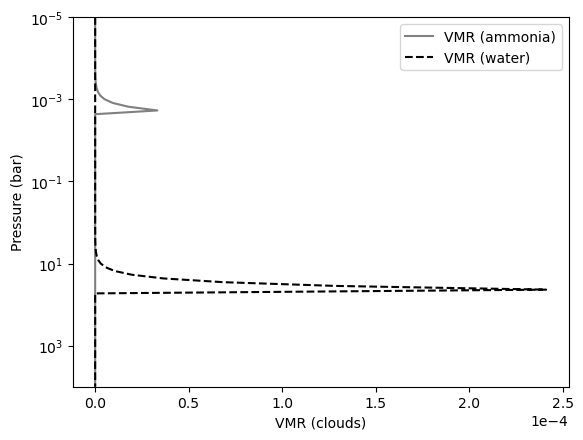

In [8]:
plt.figure()
plt.gca().get_xaxis().get_major_formatter().set_powerlimits([-3, 3])
plt.plot(VMRc_nh3, Parr, color="gray", label="VMR (ammonia)")
plt.plot(VMRc_h2o, Parr, color="black", ls="dashed", label="VMR (water)")

plt.yscale("log")
plt.ylim(1.e-5, 10000)
plt.gca().invert_yaxis()
plt.legend()
plt.xlabel("VMR (clouds)")
plt.ylabel("Pressure (bar)")
plt.savefig("vmrcloud.pdf", bbox_inches="tight", pad_inches=0.0)
plt.savefig("vmrcloud.png", bbox_inches="tight", pad_inches=0.0)
plt.show()

Compute dynamic viscosity in H2 atmosphere (cm/g/s)

In [9]:
from exojax.atm.viscosity import eta_Rosner, calc_vfactor

T = np.logspace(np.log10(1000), np.log10(2000))
vfactor, Tr = calc_vfactor("H2")
eta = eta_Rosner(T, vfactor)


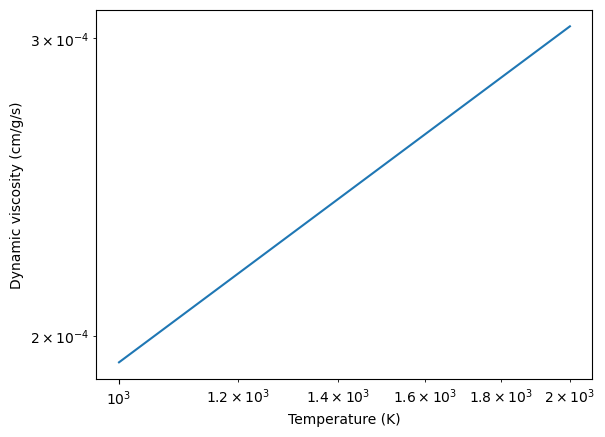

In [10]:
plt.plot(T, eta)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Temperature (K)")
plt.ylabel("Dynamic viscosity (cm/g/s)")
plt.show()

The pressure scale height can be computed using atm.atmprof.Hatm.

In [11]:
from exojax.atm.atmprof import pressure_scale_height

T = 1000  #K
mu = 2  #mean molecular weight
print("scale height=", pressure_scale_height(1.e5, T, mu), "cm")


scale height= 415722.99317937146 cm


We need a density of condensates. 

In [12]:
rhoc_enstatite = 3.192  #g/cm3 Lodders and Fegley (1998)
rhoc_Fe = 7.875

from exojax.spec.molinfo import molmass

mu = molmass("H2")
muc_nh3 = molmass("NH3")
muc_h2o = molmass("H2O")


Let's compute the terminal velocity. 
We can compute the terminal velocity of cloud particle using atm.vterm.vf.
vmap is again applied to vf.

In [14]:
from exojax.atm.viscosity import calc_vfactor, eta_Rosner
from exojax.atm.vterm import terminal_velocity
from jax import vmap

vfactor, trange = calc_vfactor(atm="H2")
rarr = jnp.logspace(-6, -4, 2000)  #cm
drho = rhoc_nh3 - rho
eta_fid = eta_Rosner(Tarr, vfactor)

g = 1.e5
vf_vmap = vmap(terminal_velocity, (None, None, 0, 0, 0))
vfs = vf_vmap(rarr, g, eta_fid, drho, rho)


Kzz/L will be used to calibrate $r_w$. following Ackerman and Marley 2001  

In [15]:
Kzz = 1.e5  #cm2/s
sigmag = 2.0
alphav = 1.3

Tbase_nh3 = T0 * (pbase_nh3)**alpha
Tbase_h2o = T0 * (pbase_h2o)**alpha

L_nh3 = pressure_scale_height(g, Tbase_nh3, mu)
L_h2o = pressure_scale_height(g, Tbase_h2o, mu)


In [16]:
Kzz/L_nh3, Kzz/L_h2o

(Array(2.1841292, dtype=float32), Array(0.8241489, dtype=float32))

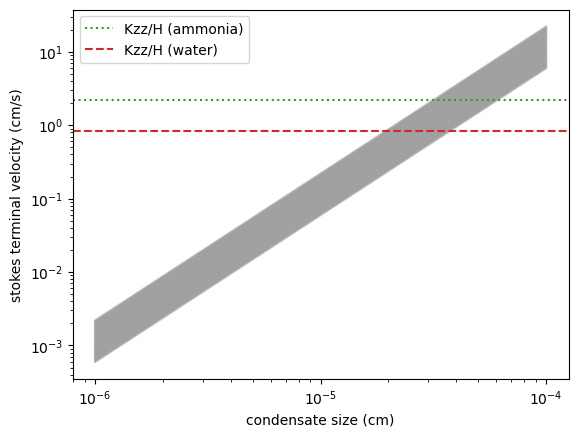

In [18]:
for i in range(0, len(Tarr)):
    plt.plot(rarr, vfs[i, :], alpha=0.2, color="gray")
plt.xscale("log")
plt.yscale("log")
plt.axhline(Kzz / L_nh3, label="Kzz/H (ammonia)", color="C2", ls="dotted")
plt.axhline(Kzz / L_h2o, label="Kzz/H (water)", color="C3", ls="dashed")
plt.ylabel("stokes terminal velocity (cm/s)")
plt.xlabel("condensate size (cm)")
plt.legend()

Find the intersection.

In [26]:
from exojax.atm.amclouds import find_rw

vfind_rw = vmap(find_rw, (None, 0, None), 0)
rw = vfind_rw(rarr, vfs, Kzz / L)


Then, $r_g$ can be computed from $r_w$ and other quantities.

In [27]:
from exojax.atm.amclouds import get_rg

rg = get_rg(rw, fsed, alphav, sigmag)


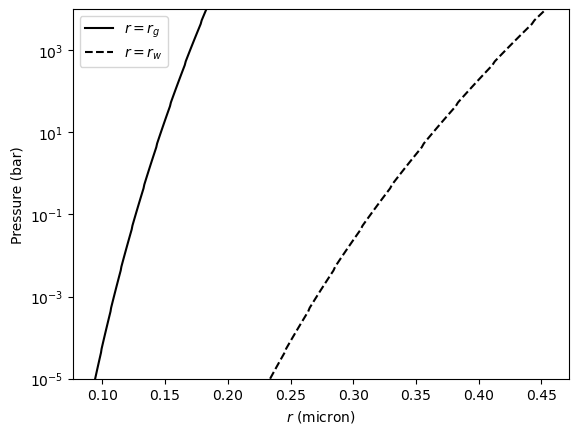

In [29]:
plt.plot(rg * 1.e4, Parr, label="$r=r_g$", color="black")
plt.plot(rw * 1.e4, Parr, ls="dashed", label="$r=r_w$", color="black")
plt.ylim(1.e-5, 10000)
plt.xlabel("$r$ (micron)")
plt.ylabel("Pressure (bar)")
plt.yscale("log")
plt.savefig("rgrw.png")
plt.legend()

We found here the particle size is basically sub-micron. So, we should use the Rayleigh scattering. 
But, here, we try to use the geometric cross section instead though this is wrong. 

In [20]:
from exojax.atm.amclouds import layer_optical_depth_cloudgeo

dtau_nh3 = layer_optical_depth_cloudgeo(Parr, muc_nh3, rhoc_nh3, mu,
                               VMRc_nh3, rg, sigmag, g)
dtau_Fe = layer_optical_depth_cloudgeo(Parr, muc_Fe, rhoc_Fe, mu, VMRc_Fe, rg, sigmag, g)


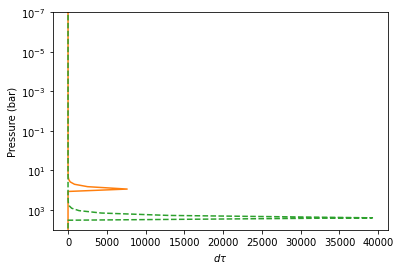

In [21]:
plt.plot(dtau_enstatite, Parr, color="C1")
plt.plot(dtau_Fe, Parr, color="C2", ls="dashed")
plt.yscale("log")
plt.ylim(1.e-7, 10000)
plt.xlabel("$d\\tau$")
plt.ylabel("Pressure (bar)")
#plt.xscale("log")
plt.gca().invert_yaxis()

Let's compare with CIA

In [22]:
#CIA
from exojax.utils.grids import wavenumber_grid

nus, wav, res = wavenumber_grid(9500, 30000, 1000, unit="AA")

from exojax.spec import contdb

cdbH2H2 = contdb.CdbCIA('.database/H2-H2_2011.cia', nus)

xsmode assumes ESLOG in wavenumber space: mode=lpf
H2-H2


/home/kawahara/exojax/src/exojax/utils/grids.py:123: UserWarning: Resolution may be too small. R=868.7669794117727
  warnings.warn('Resolution may be too small. R=' + str(resolution),


In [23]:
from exojax.spec.rtransfer import dtauCIA

mmw = 2.33  #mean molecular weight
mmrH2 = 0.74
molmassH2 = molmass("H2")
vmrH2 = (mmrH2 * mmw / molmassH2)  #VMR
dtaucH2H2=dtauCIA(nus,Tarr,Parr,dParr,vmrH2,vmrH2,\
            mmw,g,cdbH2H2.nucia,cdbH2H2.tcia,cdbH2H2.logac)

In [24]:
dtau = dtaucH2H2 + dtau_enstatite[:, None] + dtau_Fe[:, None]


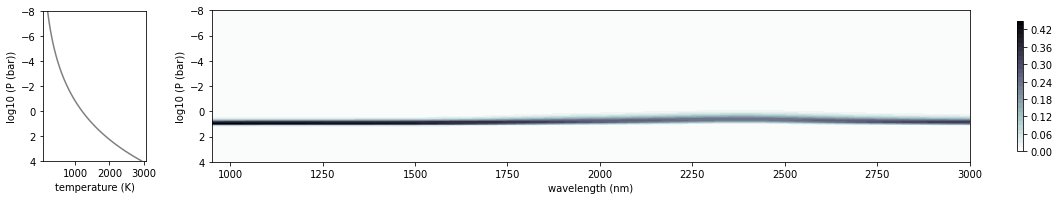

In [25]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtau, Tarr, Parr, dParr, unit="nm")
plt.show()

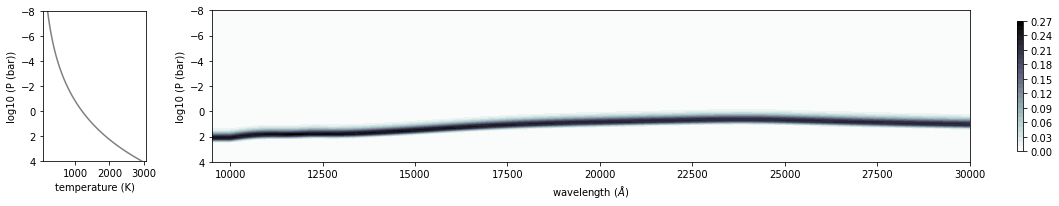

In [26]:
from exojax.plot.atmplot import plotcf

plotcf(nus, dtaucH2H2, Tarr, Parr, dParr, unit="AA")
plt.show()

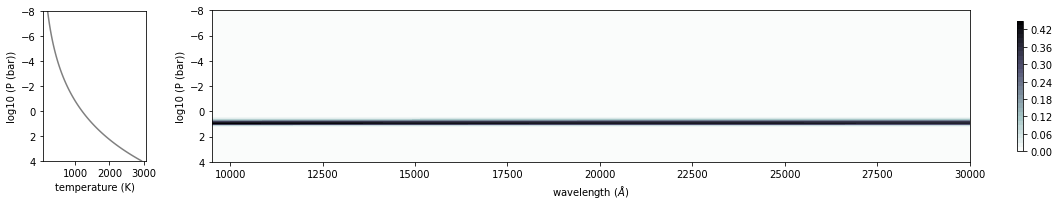

In [27]:
from exojax.plot.atmplot import plotcf

plotcf(nus,
       dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2),
       Tarr,
       Parr,
       dParr,
       unit="AA")
plt.show()

In [28]:
from exojax.spec import planck
from exojax.spec.rtransfer import rtrun

sourcef = planck.piBarr(Tarr, nus)
F0 = rtrun(dtau, sourcef)
F0CIA = rtrun(dtaucH2H2, sourcef)
F0cl = rtrun(dtau_enstatite[:, None] + np.zeros_like(dtaucH2H2), sourcef)


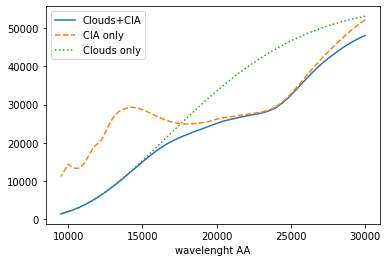

In [29]:
plt.plot(wav[::-1], F0, label="Clouds+CIA")
plt.plot(wav[::-1], F0CIA, label="CIA only", ls="dashed")
plt.plot(wav[::-1], F0cl, label="Clouds only", ls="dotted")
plt.xlabel("wavelenght AA")
plt.legend()
plt.show()